# About this notebook...

## 이 노트북에서 할 일  

### 2022-12-01
M1() 버전으로 학습을 해봅니다.
maxpool/upsampling 레이어를 빼고 conv2D, conv2D transpose들의 strides=(4, 4), kernel_size=5 로 주었고, 드랍아웃도 추가합니다.

### 2022-11-30  
- 관련 소스를 모아 패키지로 정리하고, 간단한 예를 보여준다. (그럼 directory에 파이썬 스크립트 파일들이 있고, 그걸 불러오면 그 함수들을 꺼내 쓸 수 있다.)   
- 라벨링 넣고 CVAE, 생성

## 주의
- 훈련용 데이터셋에서 target feature 일부를 가리는 기능은 안돼있습니다.  
- 파일 경로가 다음과 같아야 합니다.  

```bash
├── cvae_expamle.ipynb
├── list_attr.csv
├── rz_cvae
│   ├── ConvolutionalCondVAE.py
│   ├── Dataset.py
│   ├── image_generation_utils.py
│   ├── __init__.py
│   └── utils.py
└── sample_img
    ├── imgCrop_CHL
    │   ├── 20190820_09_CHL.JPG.jpg
    │   ├── ...
    │   └── 20200930_16_CHL.JPG.jpg
    └── imgCrop_RI
        ├── 20190820_09_RI.JPG.jpg
        ├── ...
```
       

# 데이터 불러오기
list_attr.csv 에는 이미지 경로와 센서 데이터를 합쳐서 저장해놓았다.  
index_col=0을 안하면 인덱스 column이 새로 생긴다.  

In [1]:
import pandas as pd
list_attr_path = "list_attr.csv"
pd.read_csv("list_attr.csv", index_col=0)

RI_file  \
0    sample_img/imgCrop_RI/20190820_09_RI.JPG.jpg   
1    sample_img/imgCrop_RI/20190820_10_RI.JPG.jpg   
2    sample_img/imgCrop_RI/20190820_11_RI.JPG.jpg   
3    sample_img/imgCrop_RI/20190820_12_RI.JPG.jpg   
4    sample_img/imgCrop_RI/20190820_13_RI.JPG.jpg   
..                                            ...   
378  sample_img/imgCrop_RI/20200930_12_RI.JPG.jpg   
379  sample_img/imgCrop_RI/20200930_13_RI.JPG.jpg   
380  sample_img/imgCrop_RI/20200930_14_RI.JPG.jpg   
381  sample_img/imgCrop_RI/20200930_15_RI.JPG.jpg   
382  sample_img/imgCrop_RI/20200930_16_RI.JPG.jpg   

                                           CHL_file   풍속(m/s)   풍향(deg)  \
0    sample_img/imgCrop_CHL/20190820_09_CHL.JPG.jpg  0.367769  0.194444   
1    sample_img/imgCrop_CHL/20190820_10_CHL.JPG.jpg  0.359504  0.186111   
2    sample_img/imgCrop_CHL/20190820_11_CHL.JPG.jpg  0.417355  0.200000   
3    sample_img/imgCrop_CHL/20190820_12_CHL.JPG.jpg  0.425620  0.197222   
4    sample_img/imgCrop_CHL/20190820_13_CHL.JPG.jpg  0.429752  0.216667   
..                                              ...       ...       ...   
378  sample_img/imgCrop_CHL/20200930_12_CHL.JPG.jpg  0.198347  0.108333   
379  sample_img/imgCrop_CHL/20200930_13_CHL.JPG.jpg  0.169421  0.086111   
380  sample_img/imgCrop_CHL/20200930_14_CHL.JPG.jpg  0.181818  0.136111   
381  sample_img/imgCrop_CHL/20200930_15_CHL.JPG.jpg  0.165289  0.177778   
382  sample_img/imgCrop_CHL/20200930_16_CHL.JPG.jpg  0.111570  0.166667   

       기온(°C)    수온(°C)  강수량(mm)  풍속(m/s).1  풍향(deg).1  기온(°C).1  ...  \
0    0.810881  0.808219      0.0   0.297297   0.122222  0.861538  ...   
1    0.810881  0.794521      0.0   0.334459   0.077778  0.828205  ...   
2    0.818653  0.817352      0.0   0.266892   0.097222  0.838462  ...   
3    0.816062  0.826484      0.0   0.202703   0.197222  0.853846  ...   
4    0.813472  0.831050      0.0   0.185811   0.211111  0.838462  ...   
..        ...       ...      ...        ...        ...       ...  ...   
378  0.689119  0.689498      0.0   0.263514   0.077778  0.707692  ...   
379  0.686528  0.689498      0.0   0.270270   0.083333  0.707692  ...   
380  0.696891  0.694064      0.0   0.260135   0.058333  0.707692  ...   
381  0.699482  0.680365      0.0   0.236486   0.061111  0.710256  ...   
382  0.689119  0.680365      0.0   0.260135   0.072222  0.710256  ...   

     풍향(deg).3  기온(°C).3  수온(°C).3  강수량(mm).3  풍속(m/s).4  풍향(deg).4  기온(°C).4  \
0     0.169444  0.867568  0.794643        0.0   0.240175   0.208333  0.926241   
1     0.180556  0.864865  0.785714        0.0   0.253275   0.188889  0.927660   
2     0.175000  0.864865  0.781250        0.0   0.248908   0.188889  0.924823   
3     0.202778  0.859459  0.772321        0.0   0.290393   0.211111  0.926241   
4     0.208333  0.864865  0.772321        0.0   0.331878   0.233333  0.927660   
..         ...       ...       ...        ...        ...        ...       ...   
378   0.116667  0.721622  0.611607        0.0   0.292576   0.052778  0.838298   
379   0.111111  0.729730  0.616071        0.0   0.283843   0.030556  0.859574   
380   0.200000  0.735135  0.620536        0.0   0.288210   0.008333  0.883688   
381   0.200000  0.740541  0.620536        0.0   0.305677   0.972222  0.886525   
382   0.225000  0.740541  0.620536        0.0   0.362445   0.961111  0.868085   

     수온(°C).4  강수량(mm).4  적조발생  
0    0.753036        0.0   1.0  
1    0.773279        0.0   1.0  
2    0.777328        0.0   1.0  
3    0.777328        0.0   1.0  
4    0.777328        0.0   1.0  
..        ...        ...   ...  
378  0.700405        0.0   0.0  
379  0.700405        0.0   0.0  
380  0.700405        0.0   0.0  
381  0.700405        0.0   0.0  
382  0.704453        0.0   0.0  

[383 rows x 28 columns]

In [2]:
import rz_cvae.Dataset as Dataset
from rz_cvae.utils import save_data

# Build Dataset & define the model
rz_cvae.Dataset 모듈을 이용하여 dataset을 구성합니다.

In [3]:
learning_rate = 0.001
train_size = 0.95
batch_size = 4
save_test_set = True
# S# True: the test set image IDs and other useful information will be stored in a pickle file to further uses (e.g. Image_Generation.ipynb) 

dataset = Dataset.Dataset(train_size = train_size, 
                          batch_size = batch_size, 
                          save_test_set = save_test_set)

Loading images id and attributes...
img_ids: 383 
Attributes: 26 

Splitting dataset...

Train set dimension: 363 
Test set dimension: 20 

<class 'dict'>
Test data successfully saved.


In [4]:
label_dim = 26
image_dim = [1024, 1024, 6]
latent_dim = 128
beta = 0.65

import tensorflow as tf
#from rz_cvae.ConvolutionalCondVAE import ConvCVAE, Decoder, Encoder
from rz_cvae.CVAE_M1 import CVAE_M1, Decoder, Encoder

# Model
encoder = Encoder(latent_dim)
decoder = Decoder()
model = CVAE_M1(
                encoder,
                decoder,
                label_dim = label_dim,
                latent_dim = latent_dim,
                beta = beta,
                image_dim = image_dim)

# Optiizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

#import tensorflow_addons as tfa
#optimizer = tfa.optimizers.AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False)
#optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.01)

## checkpoint 초기화
checkpoint_root를 적절히 수정합니다. 그 directory에 체크포인트가 저장됩니다.  
불러올 때는 이렇게 합니다. 만약 model_10-1.index, model_10-1.data-00.. 파일이 ./CVAE128_0.9/ 에 있다면 

```python
checkpoint.restore('CVAE128_0.9/model_10-1')
```

이렇게 불러옵니다.

In [5]:
import os

# Checkpoint path
checkpoint_root = "./CVAE_M2v3_{}_{}".format(latent_dim, train_size) 
checkpoint_name = "m0"
save_prefix = os.path.join(checkpoint_root, checkpoint_name)

# Define the checkpoint
checkpoint = tf.train.Checkpoint(module=model)


## training

In [6]:
import numpy as np
import time
from rz_cvae.utils import train_step

train_losses = []
train_recon_errors = []
train_latent_losses = []
loss = []
reconstruct_loss = []
latent_loss = []

step_index = 0
n_batches = int(dataset.train_size / batch_size)
n_epochs = 200

print("Number of epochs: {},  number of batches: {}".format(n_epochs, n_batches))

# Epochs Loop
for epoch in range(n_epochs):
    start_time = time.perf_counter()
    dataset.shuffle() # Shuffling

    # Train Step Loop
    for step_index, inputs in enumerate(dataset):
        total_loss, recon_loss, lat_loss = train_step(inputs, model, optimizer)
        train_losses.append(total_loss)
        train_recon_errors.append(recon_loss)
        train_latent_losses.append(lat_loss)

        if step_index + 1 == n_batches:
            break

    loss.append(np.mean(train_losses, 0))
    reconstruct_loss.append(np.mean(train_recon_errors, 0))
    latent_loss.append(np.mean(train_latent_losses, 0))

    exec_time = time.perf_counter() - start_time
    print("Execution time: %0.3f \t Epoch %i: loss %0.4f | reconstr loss %0.4f | latent loss %0.4f"
                        % (exec_time, epoch, loss[epoch], reconstruct_loss[epoch], latent_loss[epoch])) 

    if np.isnan([loss[-1], reconstruct_loss[-1], latent_loss[-1]]).any():
        print("loss diverged. stop training")
        print("")
        break
    
    # Save progress every epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(save_prefix + "_" + str(epoch + 1))
        print("Model saved:", save_prefix)

# Save the final model                
checkpoint.save(save_prefix)
print("Model saved:", save_prefix)


Number of epochs: 200,  number of batches: 90
IDs shuffled.
Execution time: 63.018 	 Epoch 0: loss 5.7635 | reconstr loss 5.2361 | latent loss 0.5274
IDs shuffled.
Execution time: 56.095 	 Epoch 1: loss 4.8324 | reconstr loss 4.5085 | latent loss 0.3240
IDs shuffled.
Execution time: 56.352 	 Epoch 2: loss 4.2785 | reconstr loss 4.0434 | latent loss 0.2351
IDs shuffled.
Execution time: 56.452 	 Epoch 3: loss 4.1374 | reconstr loss 3.9385 | latent loss 0.1989
IDs shuffled.
Execution time: 56.458 	 Epoch 4: loss 3.9818 | reconstr loss 3.8117 | latent loss 0.1700
Model saved: ./CVAE_M2v3_128_0.95/m0
IDs shuffled.
Execution time: 56.520 	 Epoch 5: loss 3.7663 | reconstr loss 3.6201 | latent loss 0.1462
IDs shuffled.
Execution time: 57.065 	 Epoch 6: loss 3.6508 | reconstr loss 3.5232 | latent loss 0.1276
IDs shuffled.
Execution time: 57.111 	 Epoch 7: loss 3.6099 | reconstr loss 3.4946 | latent loss 0.1154
IDs shuffled.
Execution time: 57.210 	 Epoch 8: loss 3.5038 | reconstr loss 3.3984 | 

In [8]:
#checkpoint.restore(os.path.join(checkpoint_root,'m1_10-2'))
checkpoint.restore('CVAE_M2v1_128_0.9/m1_10-2')



# Image Generation
이 아래는 위와 별개로 실행해도 됩니다.  

## 모델 정의, 체크포인트 복원
위와 같게 맞춰야 합니다.

In [15]:
# Hyper-paramters
label_dim = 26
image_dim = [1024, 1024, 6]
latent_dim = 128
beta = 0.65

batch_size = 4

In [16]:
import tensorflow as tf
from rz_cvae.CVAE_M1 import CVAE_M1, Decoder, Encoder

# Model
encoder = Encoder(latent_dim)
decoder = Decoder(batch_size = batch_size)
model = CVAE_M1(
                encoder,
                decoder,
                batch_size = batch_size,
                label_dim = label_dim,
                latent_dim = latent_dim,
                beta = beta,
                image_dim = image_dim)

In [8]:
import os

# Checkpoint path
checkpoint_root = "./CVAE_M2v3_{}_{}".format(latent_dim, train_size)
checkpoint_name = "m0"
save_prefix = os.path.join(checkpoint_root, checkpoint_name)

# Define the checkpoint
checkpoint = tf.train.Checkpoint(module=model)

In [10]:
checkpoint.restore(os.path.join(checkpoint_root,'m0_10-2'))

## test data 읽기 & 이미지 생성
folder 부분은 생성된 이미지를 저장할 경로입니다. 그런데 default값으로 저장이 꺼져있습니다.  
  
image_reconstruction()은 테스트 데이터의 입력에서 이미지를 생성하고, 입력 RI image와 생성 RI image를 비교합니다. (RI가 target feature, target label입니다.) 

In [11]:
import argparse
import json
import os
from matplotlib import pyplot as plt
import sys

import tensorflow as tf

from rz_cvae.utils import batch_generator, convert_batch_to_image_grid, read_data

# Read test_data.pickle 
test_data = read_data("./test_data")

# Saving path for generated images
folder = "./images_{}_{}_0.9/".format(latent_dim, beta)
if not os.path.exists(folder):
    os.mkdir(folder)

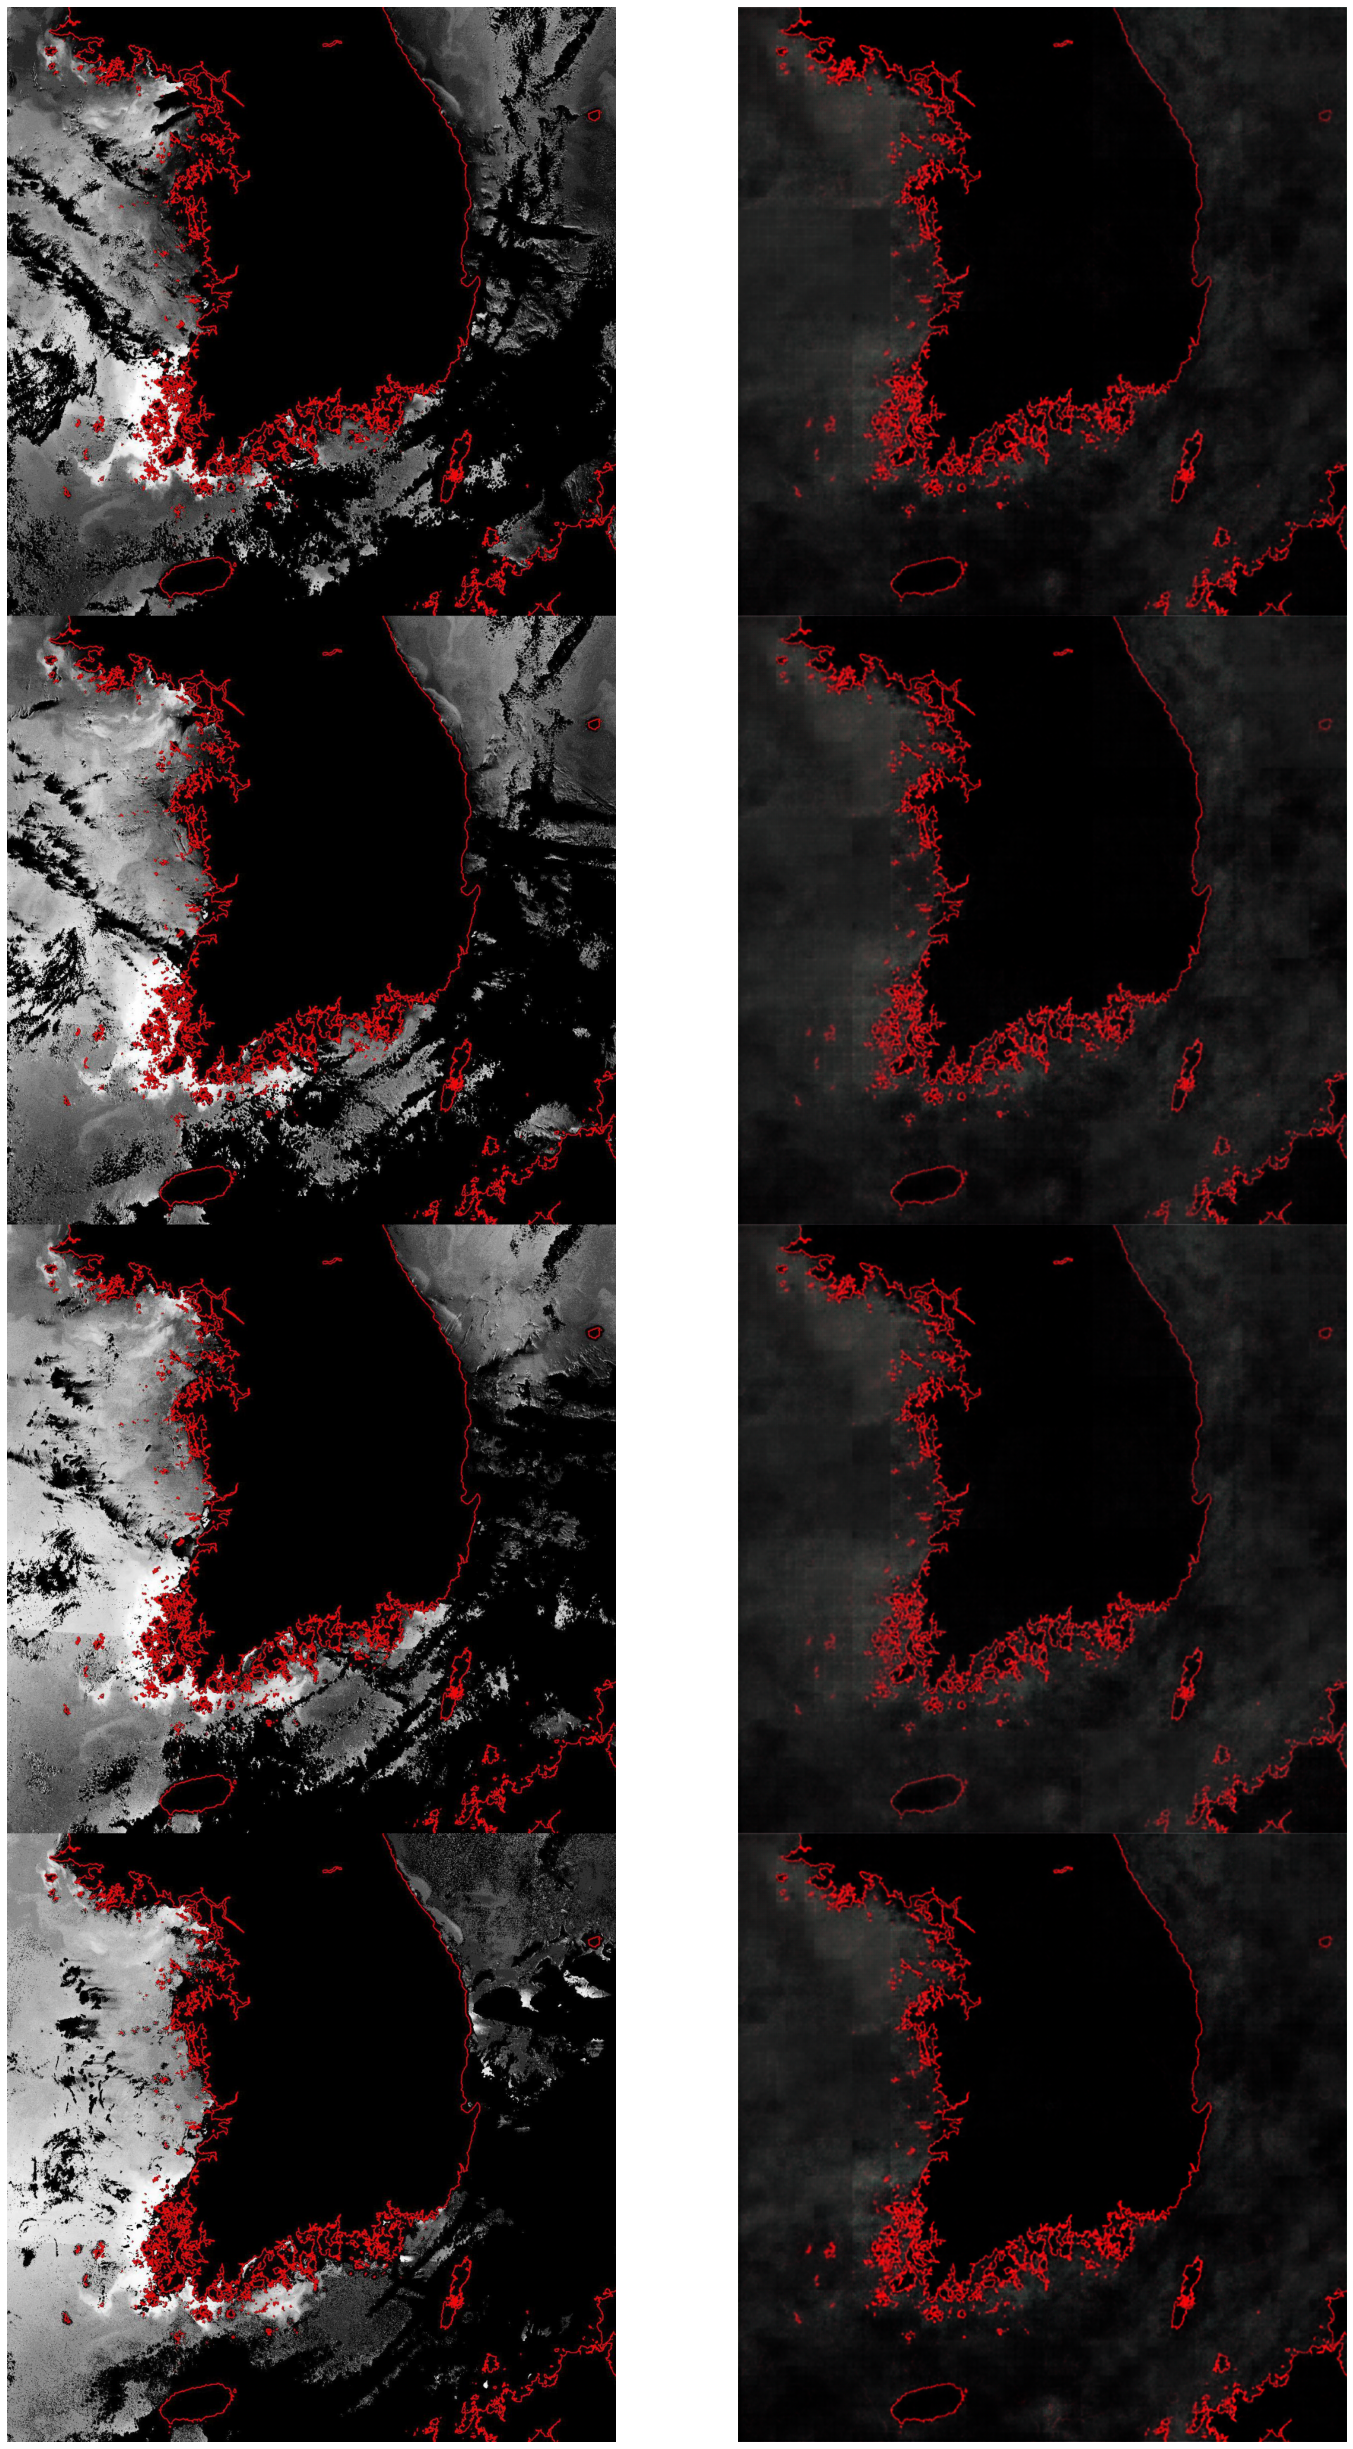

Reconstruction of a batch of test set images.


<Figure size 432x288 with 0 Axes>

In [12]:
from rz_cvae.image_generation_utils import image_generation, image_reconstruction

# Image reconstruction
image_reconstruction(model, test_data, save_path=None) 

#target_attr = None 
#image_generation(model, test_data, target_attr = None, save_path = None)


## 더 할 일
라벨링 된 데이터로 CVAE를 학습시키고, 이미지 생성한다: 라벨을 어떻게 입력할 것인가?? label is a vertices of polygons surronding RI denssed region.  
라벨을 어떻게 학습시킬 것인가? 좌표값으로 주어진 것은 사실 픽셀과 밀접한 관계가 있는데 latent vector에서는 그것이 다 해체된 상태이다. 내가 볼땐 폴리곤들을 특정 색깔로 칠해서 그거를 input에만 넣고 output에서는 배제하면 좋을 거 같다. 근데 latent vector로 꼭 넣어야 하나? 만약 그렇다면 어떻게 넣어야 할까? 좌표값들을 읽어서 무게중심 좌표랑 effective radius 같은 것으로 면적을 표시하게 하고 중요한 것 몇 개 남기면 학습하기에 괜찮은 feature가 될 것이다. 그래서 cluster 별로 점이 찍히는 거지. 근데 그렇게 할 거면 라벨링을 저렇게 자세히 할 필요가 없었잖아.  
좌표값을 그대로 입력하는 것은 무리가 있다. 길이 차이가 너무 심하다. 시퀀스가 들어가는 것도 아닌데 어떻게 넣나? latent dimension이 256인데 맵 형식으로 넣을 수는 없다.
Seq2seq 번역기에서 입력문장 넘기듯이 hidden state를 넣으면 어떨까 싶다.  


__goal of this notebook is...__  
- train conditional VAE with labeled data  
- generate RI image with label  
- validate and initiate library for this project  
but in korean mostly.